In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import joblib

In [2]:
# Load the saved CNN model
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Freeze CNN layers
for layer in cnn_model.layers:
    layer.trainable = False

In [3]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

In [4]:
# Image preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

54/54 [==============================] - 134s 2s/step


In [6]:
# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [7]:
print(f"Original feature dimensions: {train_features.shape[1]}")

Original feature dimensions: 86528


In [8]:
# Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

In [9]:
print(f"Reduced feature dimensions (PCA): {train_features_pca.shape[1]}")

Reduced feature dimensions (PCA): 389


In [10]:
# Train SVM classifier
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(train_features_pca, train_labels)

print("SVM model trained using CNN features with PCA.")


SVM model trained using CNN features with PCA.


In [11]:
# Predict on test set
test_predictions = svm_classifier.predict(test_features_pca)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA: {accuracy:.4f}")

Test Accuracy with PCA: 0.8672


In [12]:
# Classification report
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.84      0.72      0.77       542
   MALIGNANT       0.88      0.94      0.91      1182

    accuracy                           0.87      1724
   macro avg       0.86      0.83      0.84      1724
weighted avg       0.87      0.87      0.86      1724



In [13]:
# Save the trained SVM model and PCA
svm_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\svm_model_with_pca.pkl'
pca_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl'
scaler_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl'

joblib.dump(svm_classifier, svm_model_path)
joblib.dump(pca, pca_model_path)
joblib.dump(scaler, scaler_model_path)

print(f"SVM model saved at {svm_model_path}")
print(f"PCA model saved at {pca_model_path}")
print(f"Scaler saved at {scaler_model_path}")

SVM model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\svm_model_with_pca.pkl
PCA model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl
Scaler saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl


1/1 [==============================] - 0s 488ms/step


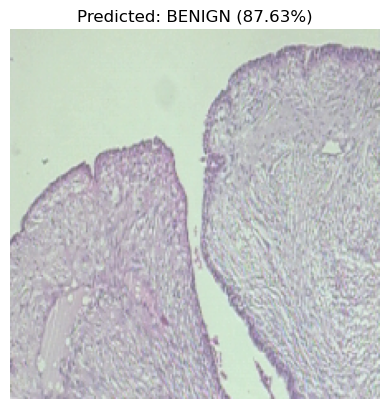

Prediction Probabilities:
BENIGN: 0.88
MALIGNANT: 0.12


In [14]:
# Predict a single image
def predict_image(image_path, model, scaler, pca, svm_classifier, class_indices):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    features = model.predict(img_array)
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    prediction = svm_classifier.predict(features_pca)
    probabilities = svm_classifier.predict_proba(features_pca)[0]
    
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    confidence = max(probabilities)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\phyllodes_tumor\SOB_B_PT_14-21998AB\40X\SOB_B_PT-14-21998AB-40-007.png"
predict_image(image_path, cnn_model, scaler, pca, svm_classifier, train_generator.class_indices)


1/1 [==============================] - 0s 171ms/step


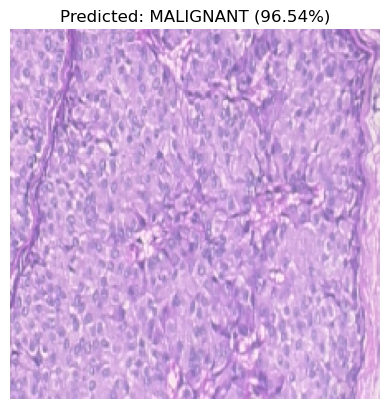

Prediction Probabilities:
BENIGN: 0.03
MALIGNANT: 0.97


In [15]:
# Predict a single image
def predict_image(image_path, model, scaler, pca, svm_classifier, class_indices):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    features = model.predict(img_array)
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    prediction = svm_classifier.predict(features_pca)
    probabilities = svm_classifier.predict_proba(features_pca)[0]
    
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    confidence = max(probabilities)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-014.png"
predict_image(image_path, cnn_model, scaler, pca, svm_classifier, train_generator.class_indices)
